In [19]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [20]:
def black_scholes_price(S, K, T, r, sigma, is_call=True):

    S = np.asarray(S)
    T = np.asarray(T)
    
    # Use np.where to check  T <= 0 condition on numpy array:
    payoff = np.where(is_call, np.maximum(0.0, S - K), np.maximum(0.0, K - S))
    
    # Compute d1 and d2 if T > 0.
    d1 = np.where(
        T > 0,
        (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),
        0.0 # T <= 0
    )
    d2 = np.where(T > 0, d1 - sigma * np.sqrt(T), 0.0)
    
    # Black-Scholes price where T > 0
    sign = 1 if is_call else -1
    bs_price = sign * (S * norm.cdf(sign * d1) - K * np.exp(-r * T) * norm.cdf(sign * d2))
    
    # Where T > 0, use the BS price; otherwise, use payoff.
    return np.where(T > 0, bs_price, payoff)


def black_scholes_delta(S, K, T, r, sigma, is_call=True):
    
    S = np.asarray(S)
    T = np.asarray(T)
    
    # For T <= 0, define delta as the derivative of the payoff:
    # For calls: 1 if S > K, else 0; for puts: 0 if S > K, else -1.
    delta_payoff = np.where(is_call, np.where(S > K, 1.0, 0.0), np.where(S > K, 0.0, -1.0))
    
    # Compute d1 where T > 0
    d1 = np.where(
        T > 0,
        (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),
        0.0
    )
    
    # Compute the Black-Scholes delta for T > 0.
    if is_call:
        delta_bs = norm.cdf(d1)
    else:
        delta_bs = norm.cdf(d1) - 1  # For puts
    
    # Use BS delta for T > 0; otherwise, use the payoff delta.
    return np.where(T > 0, delta_bs, delta_payoff)


In [21]:
def initialize_simulation(S0, K, T, r, sigma, option_pricer, option_delta, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    # Calculate initial option price and delta for each path
    initial_option_price = option_pricer(S0, K, T, r, sigma)
    initial_delta = option_delta(S0, K, T, r, sigma)
    
    # Set up initial hedge portfolio
    shares_held = initial_delta
    cash_account = initial_option_price - shares_held * S0
    portfolio_value = cash_account + shares_held * S0  # should equal initial_option_price

    # current_S will be updated during the simulation
    current_S = S0.copy()
    
    return initial_option_price, cash_account, shares_held, portfolio_value, current_S

In [22]:
def dynamic_delta_hedging(S0, K, T, r, sigma, steps, dt, option_pricer, option_delta):
    
    n = S0.shape[0]
    
    # Preallocate arrays for all simulation values:
    stock_prices   = np.empty((steps + 1, n))
    option_prices  = np.empty((steps + 1, n))
    portfolio_values = np.empty((steps + 1, n))
    deltas         = np.empty((steps + 1, n))
    cash_accounts  = np.empty((steps + 1, n))
    shares_held_list = np.empty((steps + 1, n))
    
    # Initialize at t = 0
    stock_prices[0, :] = S0
    initial_option_price = option_pricer(S0, K, T, r, sigma)
    option_prices[0, :] = initial_option_price
    initial_delta = option_delta(S0, K, T, r, sigma)
    deltas[0, :] = initial_delta
    shares_held_list[0, :] = initial_delta
    cash_accounts[0, :] = initial_option_price - initial_delta * S0
    portfolio_values[0, :] = cash_accounts[0, :] + shares_held_list[0, :] * S0
    
    # current_S holds the evolving stock price per simulation path
    current_S = S0.copy()
    
    for i in range(1, steps + 1):
        # Decrease time to expiry
        time_to_expiry = T - i * dt
        
        # Simulate stock price evolution using geometric Brownian motion
        z = np.random.normal(0, 1, size=n)
        current_S = current_S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        stock_prices[i, :] = current_S
        
        # Recalculate option price and delta for the new state
        current_option_price = option_pricer(current_S, K, time_to_expiry, r, sigma)
        option_prices[i, :] = current_option_price
        current_delta = option_delta(current_S, K, time_to_expiry, r, sigma)
        deltas[i, :] = current_delta
        
        # Compute the change in delta, which is the number of shares to trade
        delta_change = current_delta - shares_held_list[i - 1, :]
        shares_to_trade = delta_change
        
        # Update the cash account: trading cost and risk-free growth
        cash_accounts[i, :] = cash_accounts[i - 1, :] - shares_to_trade * current_S
        # Let the cash account grow with the risk-free rate over dt
        cash_accounts[i, :] *= np.exp(r * dt)
        
        # Update the shares held and portfolio value
        shares_held_list[i, :] = shares_held_list[i - 1, :] + shares_to_trade
        portfolio_values[i, :] = cash_accounts[i, :] + shares_held_list[i, :] * current_S
    
    return stock_prices, option_prices, portfolio_values, deltas, cash_accounts, shares_held_list

In [23]:
def PnL(current_S, portfolio_values, initial_option_price, K):
    
    # Option payoff at expiration (for a call option)
    option_payoff = np.maximum(0, current_S - K)
    final_portfolio_value = portfolio_values[-1, :]
    diff = final_portfolio_value - option_payoff
    
    # Print summary statistics (or you can return these arrays for further analysis)
    # print("Initial Option Prices:", initial_option_price)
    # print("Final Portfolio Values:", final_portfolio_value)
    # print("Option Payoffs at Expiration:", option_payoff)
    # print("Differences (PnL):", diff)
    
    return diff

In [24]:
# Simulation parameters
n_paths = 100  # number of simulation paths
S0 = np.full(n_paths, 100.0)  # initial stock price for each path
K = 100.0
T = 1.0
r = 0.05
sigma = 0.2
steps = 10_000  # daily steps in one year
dt = T / steps

In [25]:
# Initialize simulation
init_price, cash_account, shares_held, port_value, current_S = initialize_simulation(
        S0, K, T, r, sigma, black_scholes_price, black_scholes_delta, seed=42)

    # Run dynamic hedging simulation
stock_prices, option_prices, portfolio_values, deltas, cash_accounts, shares_held_list = dynamic_delta_hedging(
        S0, K, T, r, sigma, steps, dt, black_scholes_price, black_scholes_delta)

    # Compute PnL at expiration
pnl = PnL(stock_prices[-1, :], portfolio_values, init_price, K)

/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_43883/307967165.py:12: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),
/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_43883/307967165.py:37: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),


/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_43883/307967165.py:12: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),
/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_43883/307967165.py:37: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)),


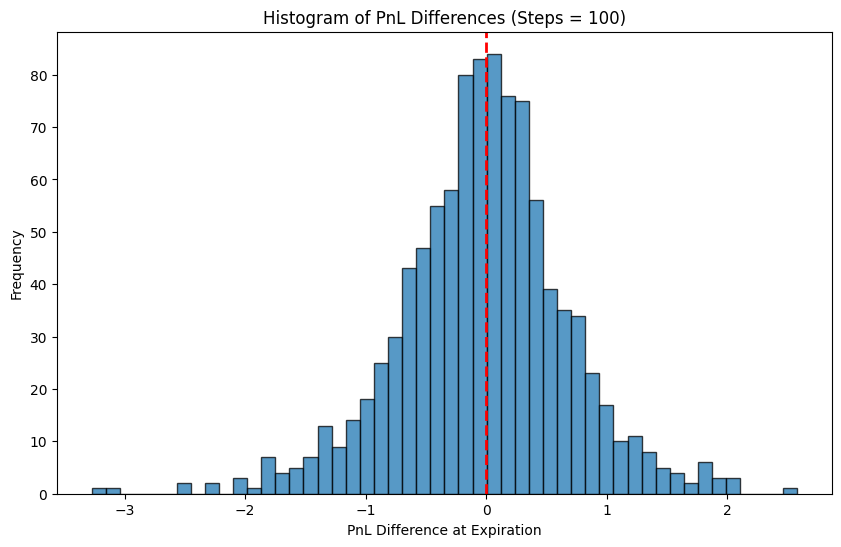

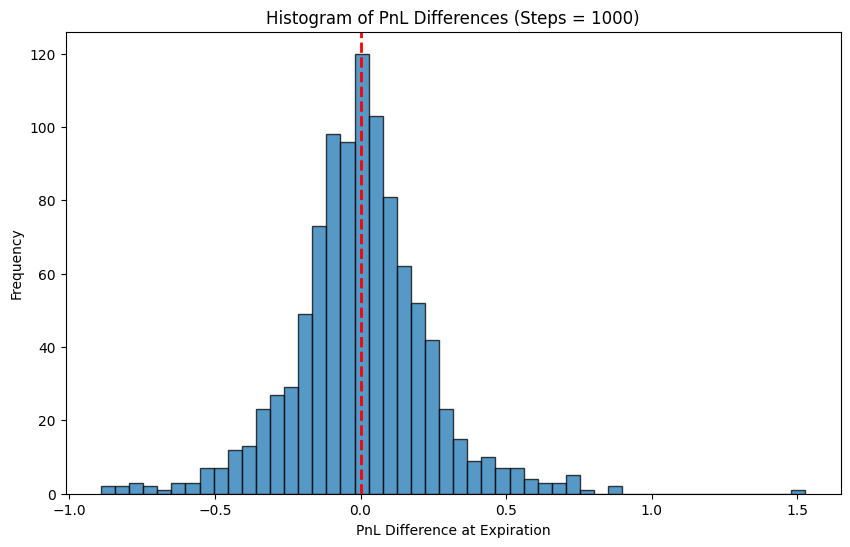

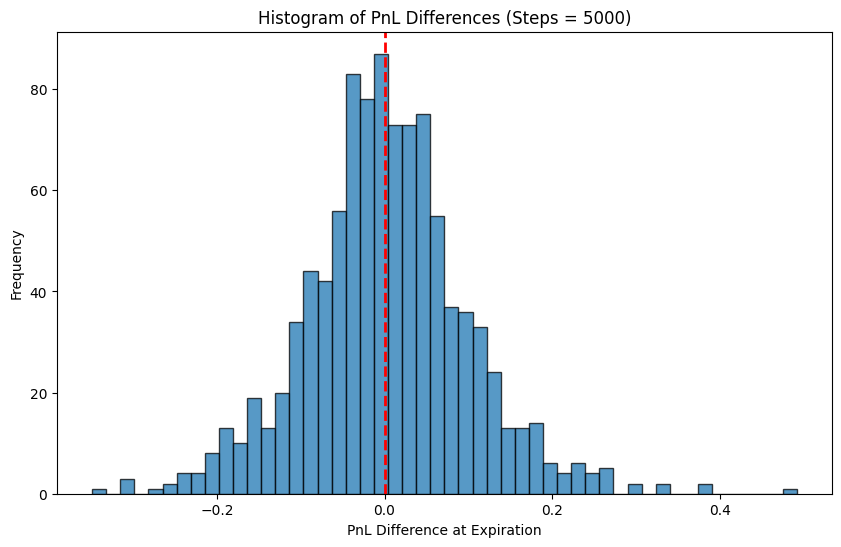

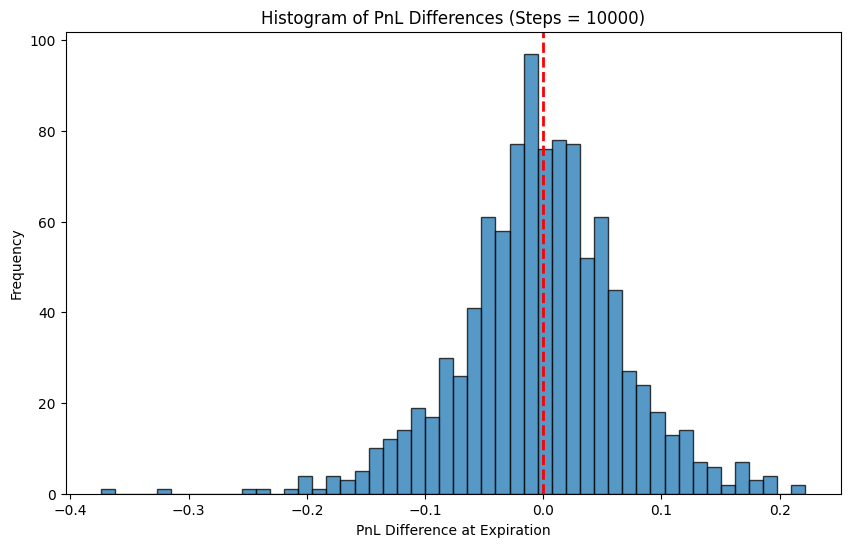

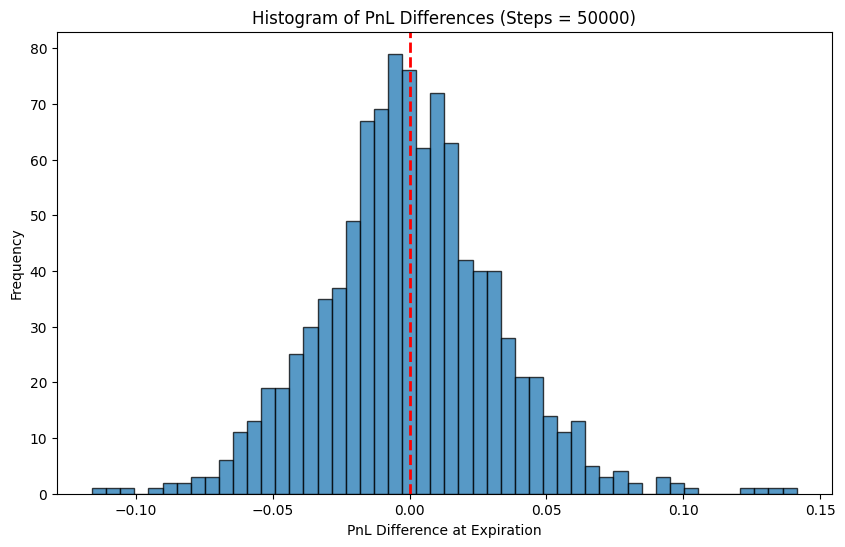

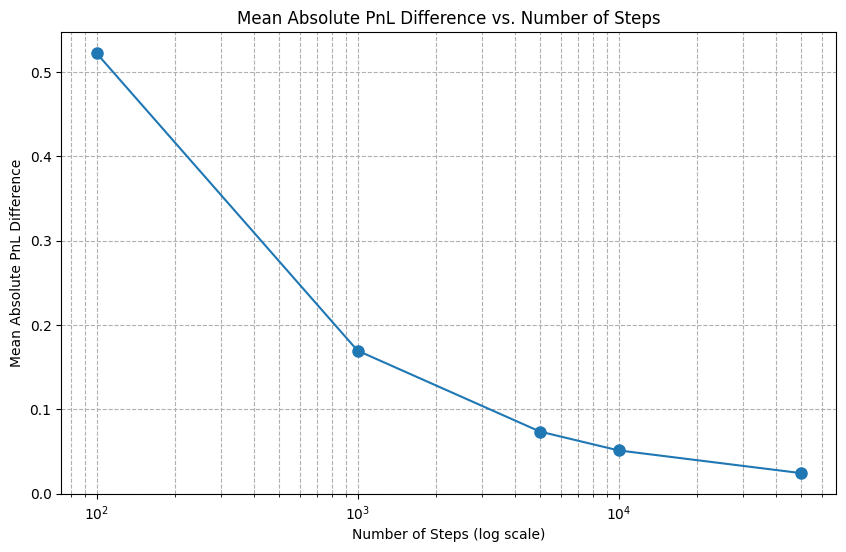

In [27]:
import numpy as np
import matplotlib.pyplot as plt

n_paths = 1000          # Number of simulation paths
S0 = np.full(n_paths, 100.0)  # Initial stock prices for all paths
K = 100.0                # Strike price
T = 1.0                  # Time to maturity (years)
r = 0.05                 # Risk-free rate
sigma = 0.2              # Volatility

# As dt -> 0, final_portfolio_values - option_payoffs -> 0 as well
steps_list = [100, 1000, 5000, 10000, 50000]

# Collect means
mean_abs_diff_list = []


for steps in steps_list:
    dt = T / steps  # Define dt for each simulation
    
    
    stock_prices, option_prices, portfolio_values, deltas, cash_accounts, shares_held_list = dynamic_delta_hedging(
        S0, K, T, r, sigma, steps, dt, black_scholes_price, black_scholes_delta)
    
    final_stock_prices = stock_prices[-1, :]        # Final stock prices 
    final_portfolio_values = portfolio_values[-1, :]  # Final portfolio values 
    
    # Payoff at expiration (call option)
    option_payoffs = np.maximum(0, final_stock_prices - K)
    
    # (PnL errors) for each path:
    differences = final_portfolio_values - option_payoffs
    
    # Compute the mean for this simulation
    mean_abs_diff = np.mean(np.abs(differences))
    mean_abs_diff_list.append(mean_abs_diff)
    
    
    plt.figure(figsize=(10, 6))
    plt.hist(differences, bins=50, edgecolor='black', alpha=0.75)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('PnL Difference at Expiration')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of PnL Differences (Steps = {steps})')
    plt.show()

# Plot mean of the difference against the number of steps
plt.figure(figsize=(10, 6))
plt.plot(steps_list, mean_abs_diff_list, 'o-', markersize=8)
plt.xscale('log')
plt.xlabel('Number of Steps (log scale)')
plt.ylabel('Mean Absolute PnL Difference')
plt.title('Mean Absolute PnL Difference vs. Number of Steps')
plt.grid(True, which="both", ls="--")
plt.show()
